In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

C:\Users\JeongYeong\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
bins = 100
dx = 1 / (bins - 1)
inf = 20000
num_model = 2
#h_bar = 6.63 * 10**(-34)
#m = 9.11 * 10**(-31)
#C = -h_bar**2 / (2*m)
C = -1
A = C / dx**2

pot = np.zeros([1, bins])
pot[0, 0] = inf; pot[0, -1] = inf;
pot = tf.constant(pot, shape=[1, bins], dtype=tf.float32, name='potential')
train = tf.placeholder(tf.float32, [1, bins], name='train')
#train = tf.random_normal([1, bins])

In [11]:
ivp = []
itr = 100000
init = np.random.normal(scale=10, size=[1,bins])
for i in range(itr):
    temp = np.random.normal(size=[1,bins], scale=1000)
    ivp.append(init+temp)
ivp = np.array(ivp)
print(ivp.shape)

(100000, 1, 100)


In [12]:
def make_var(number, bins):
    w = tf.Variable(tf.random_normal([bins, bins]), name='weight%d'%(number))
    b = tf.Variable(tf.random_normal([1, bins]), name='bias%d'%(number))
    return w, b

def cal_model(x, w, b):
    return tf.add(tf.matmul(x, w), b)

def cal_hamiltonian(psi, pot, dx, A):
    psi1 = tf.concat([tf.slice(psi, [0, 1], [1, bins-1]), [[psi[0, -1]]]], 1)
    psi2 = tf.concat([[[psi[0, 0]]], tf.slice(psi, [0, 0], [1, bins-1])], 1)
    #psi1 = tf.concat([tf.slice(psi, [0, 1], [1, bins-1]), [[0.]]], 1)
    #psi2 = tf.concat([[[0.]], tf.slice(psi, [0, 0], [1, bins-1])], 1)
    dy2 = tf.subtract(2*psi, tf.add(psi1, psi2))
    H = tf.add(tf.multiply(psi, pot), A * dy2)
    return H

def cal_energy(psi, pot, dx, A):
    psi1 = tf.concat([tf.slice(psi, [0, 1], [1, bins-1]), [[psi[0, -1]]]], 1)
    psi2 = tf.concat([[[psi[0, 0]]], tf.slice(psi, [0, 0], [1, bins-1])], 1)
    #psi1 = tf.concat([tf.slice(psi, [0, 1], [1, bins-1]), [[0.]]], 1)
    #psi2 = tf.concat([[[0.]], tf.slice(psi, [0, 0], [1, bins-1])], 1)
    dy2 = tf.subtract(2*psi, tf.add(psi1, psi2))
    E = tf.add(tf.multiply(tf.square(psi), pot), tf.multiply(psi, A * dy2))
    return E

def cal_variance(psi, E):
    # didn't use
    diff = tf.square(tf.subtract(E[1:-1], psi[1:-1]))
    return tf.reduce_mean(diff)

def integrate_simps(f, bins, dx):
    # didn't use
    if (bins-1)%3 == 0:
        ff = f[0, 1:] # f1 to fend
        ff = tf.transpose(tf.reshape(ff, [-1, 3]))
        row12 = tf.reduce_sum(ff[0: 2])
        row3 = tf.reduce_sum(ff[2])
        ssum = tf.add(2 * row3, 3 * row12)
        ssum = 3/8 * dx * tf.add(f[0, 0], tf.subtract(ssum, 2 * f[0, -1]))
    else:
        cc = [1, 4, 2]
        n = bins - (bins-1)%3
        ff = tf.slice(f, [0, 0], [1, n])
        ssum = integrate_simps(ff, n, dx)
        for i in range(bins - n + 1):
            ssum = tf.add(ssum, f[0, -(i+1)] * cc[i] * dx/3)
    return ssum

In [13]:
for i in range(num_model):
    w_temp, b_temp = make_var(i, bins)
    exec('w%d = w_temp'%(i))
    exec('b%d = b_temp'%(i))
    
    if i == 0:
        psi = cal_model(train, w0, b0)
    else:
        exec('psi = cal_model(psi, w%d, b%d)'%(i, i))
    psi = tf.divide(psi, tf.sqrt(tf.reduce_sum(tf.square(psi))))
    psi = tf.nn.tanh(psi)
#psi = tf.divide(psi, tf.sqrt(tf.reduce_mean(tf.square(psi))))
H = cal_hamiltonian(psi, pot, dx, A) # resize psi (delete both sides end points)
# var = cal_variance(psi, H)
# energy = integrate_simps(tf.multiply(psi2, H), bins, dx)
# cost = tf.add(energy**2, psi2[0, 0]**2 + psi2[0, -1]**2, name='cost')
energy = tf.reduce_mean(tf.square(tf.multiply(psi, H)))
# energy = tf.reduce_mean(energy)
# psil = tf.concat([[psi[0,1:]],[[0.]]],1)
# psir = tf.concat([[[0.]],[psi[0,:-1]]],1)
# energy = tf.reduce_mean(tf.subtract(tf.multiply(tf.square(psi),tf.add(pot,1.*bins*bins)),tf.multiply(tf.multiply(tf.add(psil,psir),psi),0.5*bins*bins)))
# cost = tf.square(energy, name='cost')
cost = energy

In [19]:
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [20]:
# sum_var = tf.summary.scalar('variance', var)
#sum_cost = tf.summary.scalar('cost', cost)
sum_energy = tf.summary.scalar('energy', energy)
sum_weight = tf.summary.histogram('weight0', w0)
sum_bias = tf.summary.histogram('bias0', b0)
# sum_energy = tf.summary.histogram('energy', energy) 


In [21]:
directory = './new_1'
graph = [];
with tf.Session() as sess:
    writer = tf.summary.FileWriter(directory)
    writer.add_graph(sess.graph)
    
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    
    #init = np.random.normal(size=[1, bins])
    
    for i in tqdm_notebook(range(itr)):
        summary, psi_val, _ = sess.run([merged, psi, opt], feed_dict={train: ivp[i]})
        writer.add_summary(summary, global_step=i)
        if i%1000 == 0:
            graph.append(psi_val)
        
    H_val, psi_val, pot_val, w_val, b_val = sess.run([H, psi, pot, w0, b0], feed_dict={train: ivp[i]})#, feed_dict={train: init})
    

-45.707066
45.707066


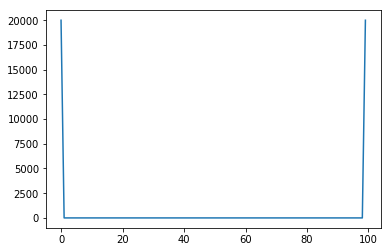

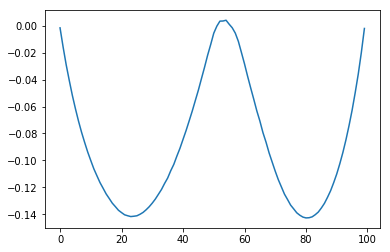

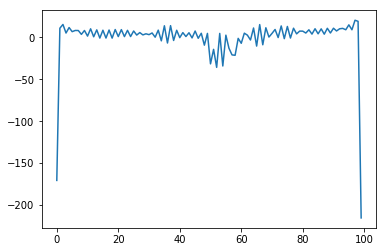

In [22]:
a1 = np.sum(np.multiply(psi_val[0], H_val[0])); print(a1)
a2 = np.sum(np.multiply(psi_val[0], -H_val[0])); print(a2)

plt.plot(pot_val[0]); plt.show()
plt.plot(psi_val[0]); plt.show()
#plt.plot(H_val[0])
plt.plot(H_val[0]); plt.show()
#plt.legend('V', 'psi', 'H')



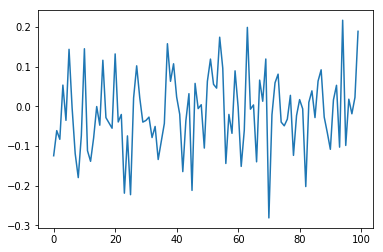

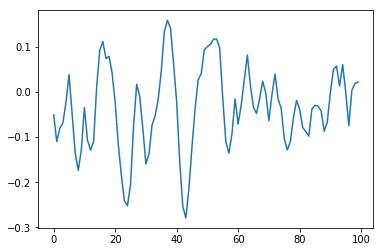

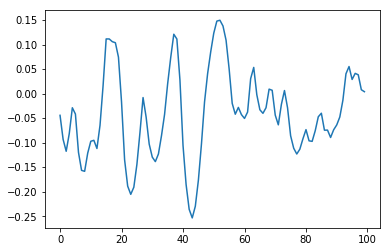

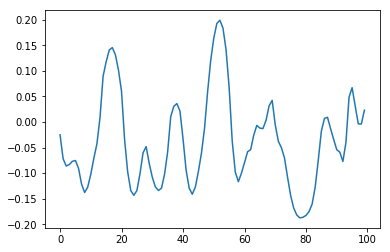

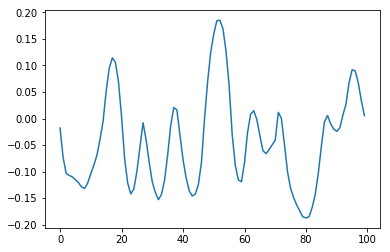

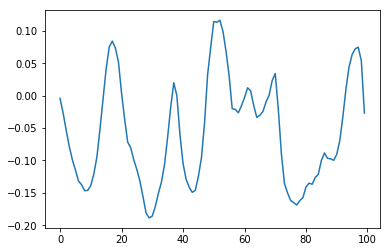

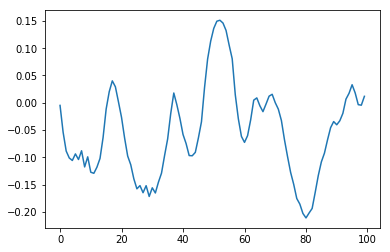

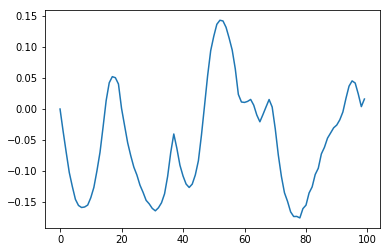

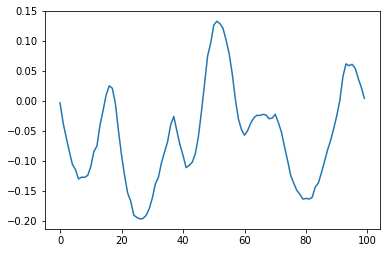

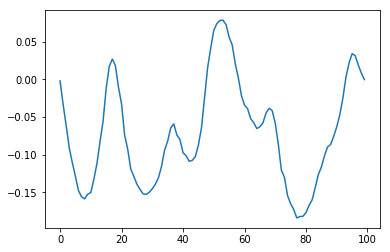

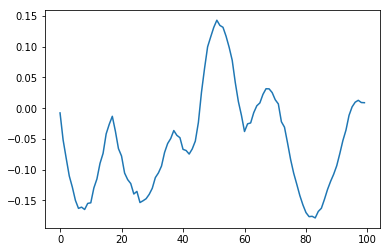

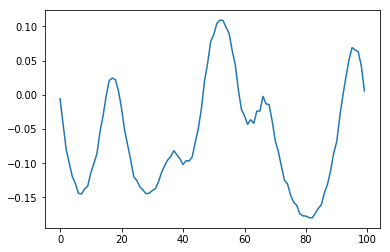

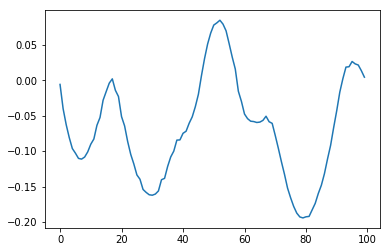

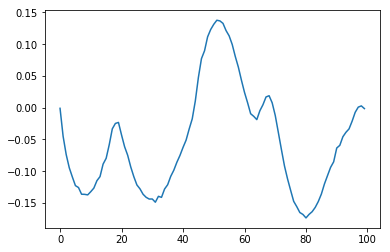

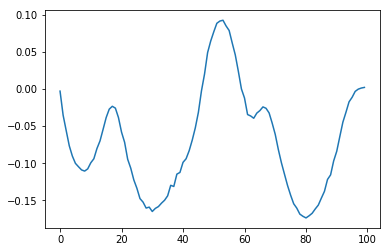

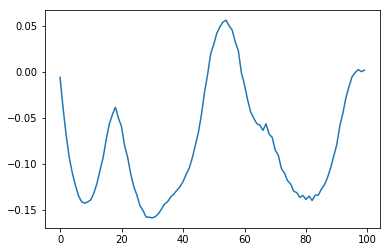

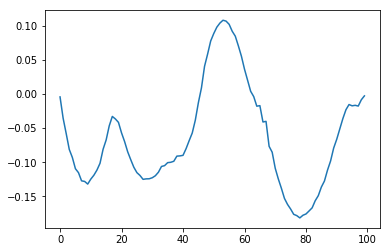

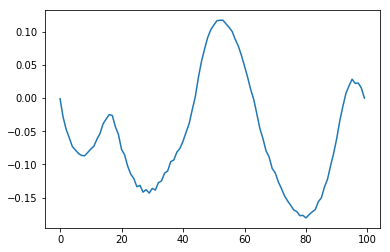

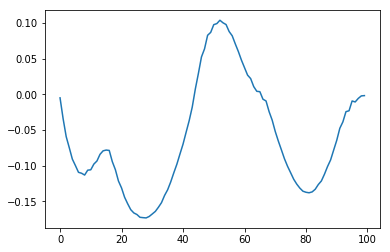

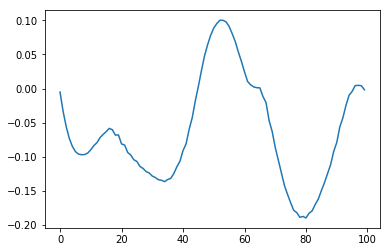

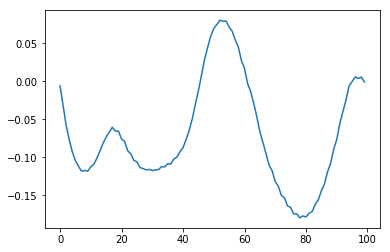

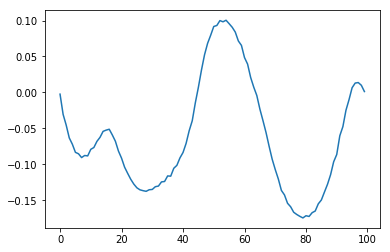

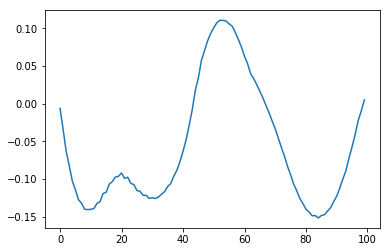

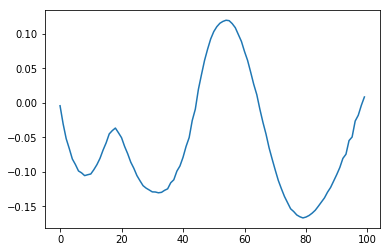

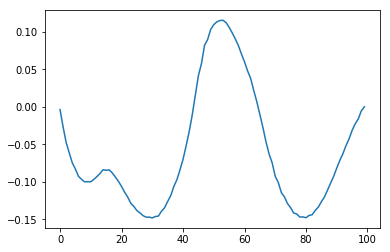

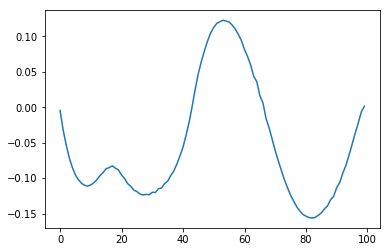

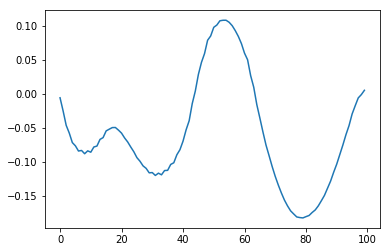

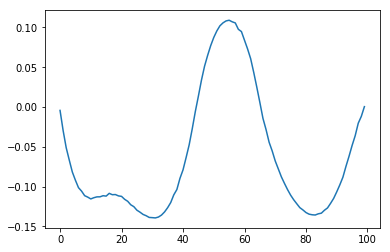

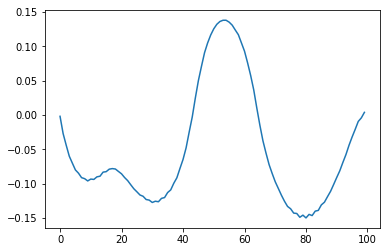

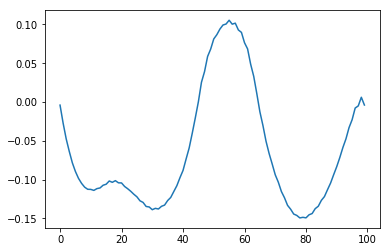

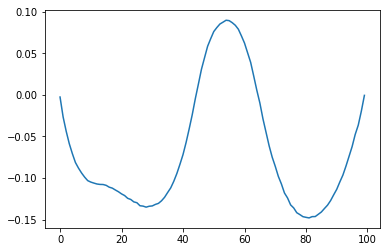

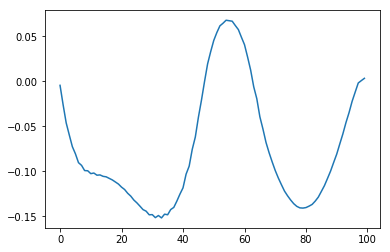

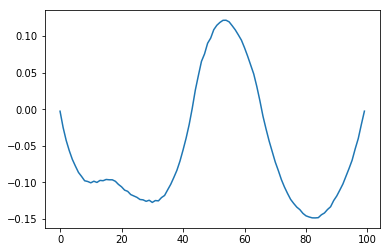

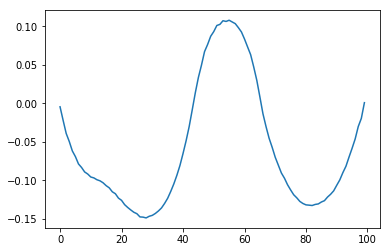

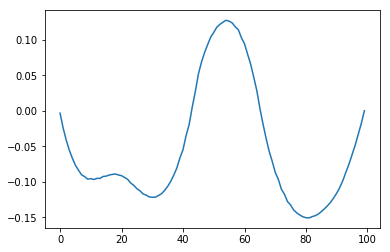

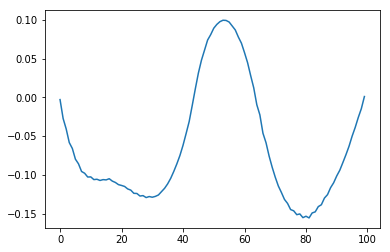

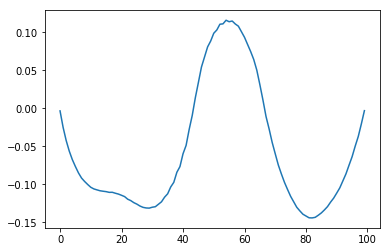

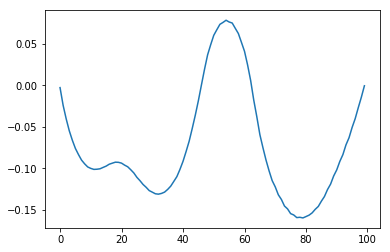

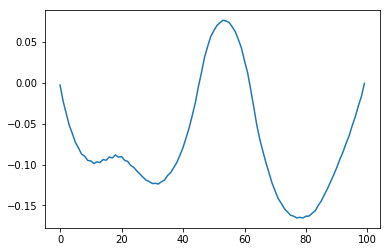

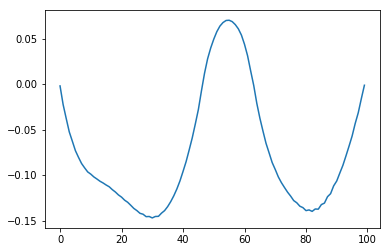

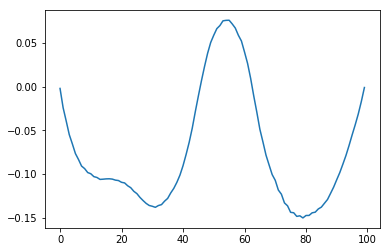

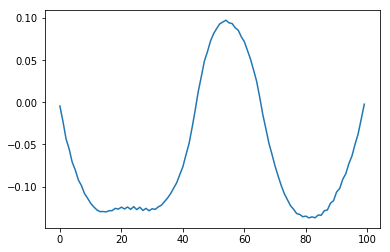

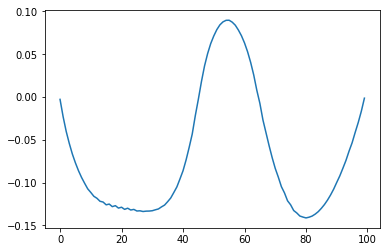

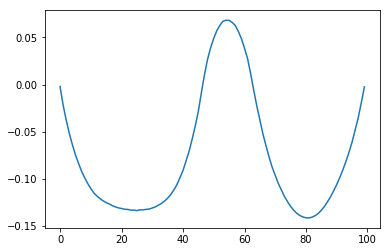

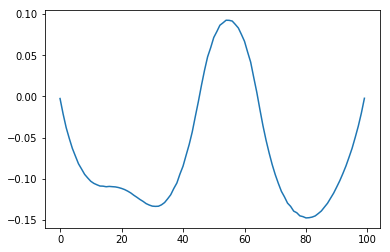

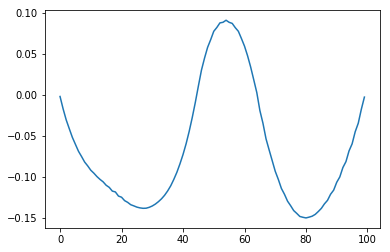

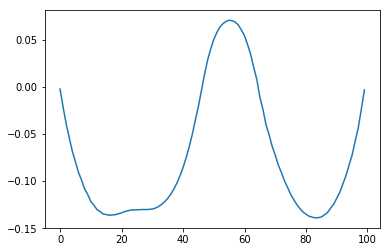

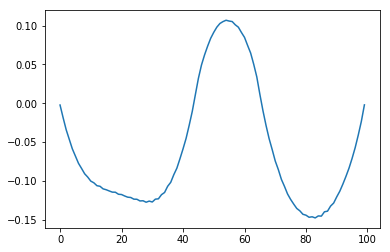

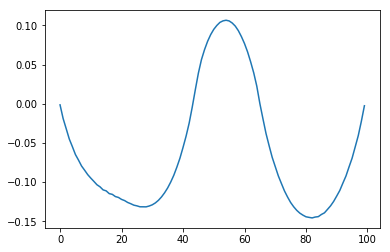

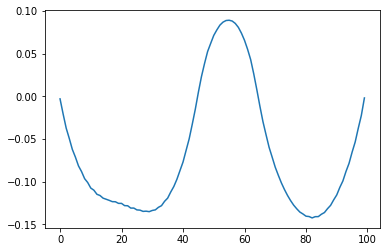

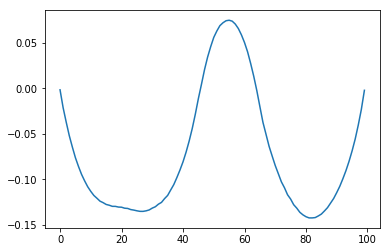

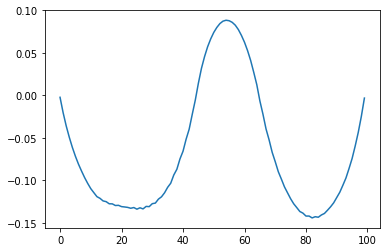

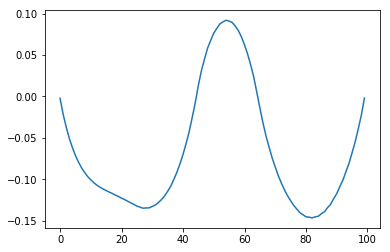

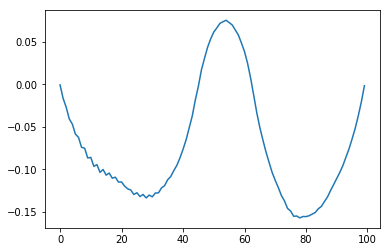

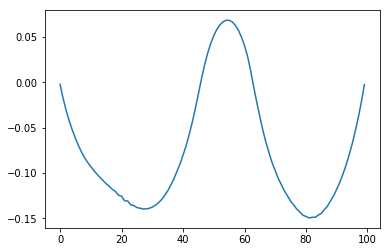

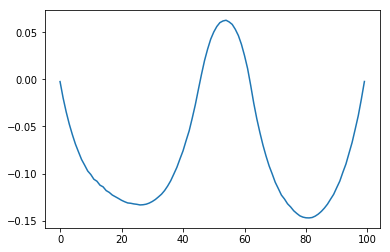

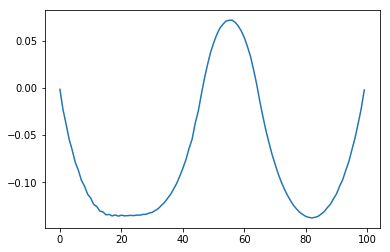

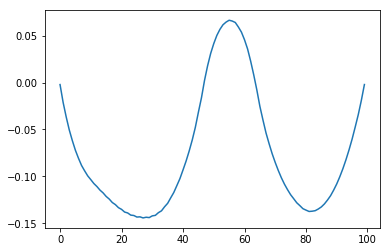

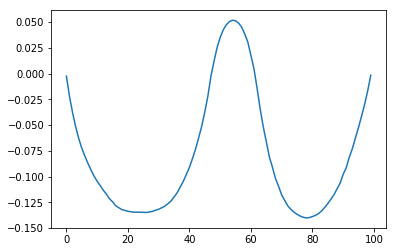

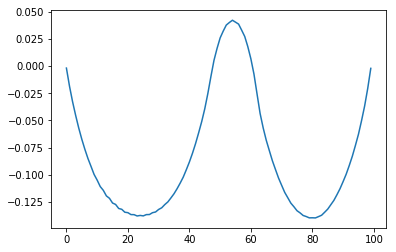

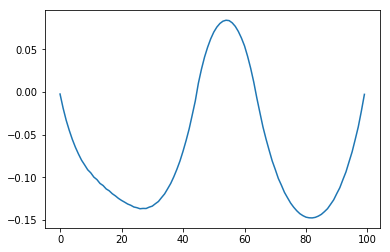

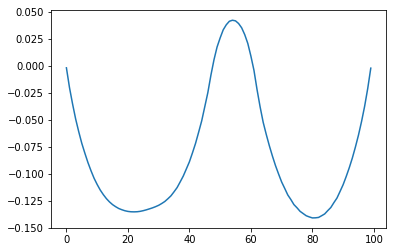

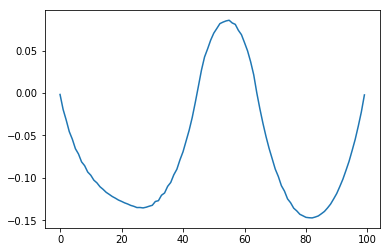

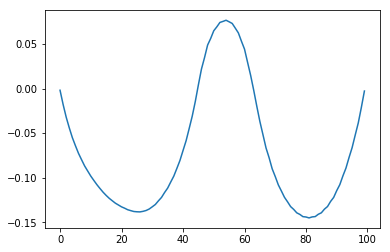

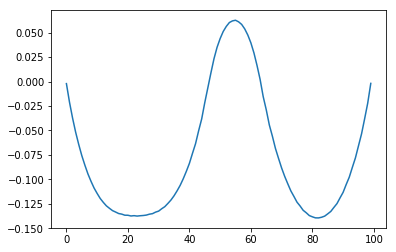

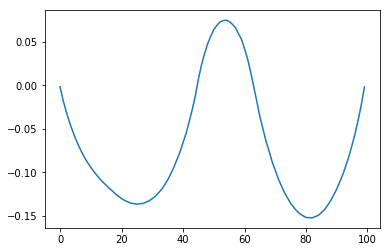

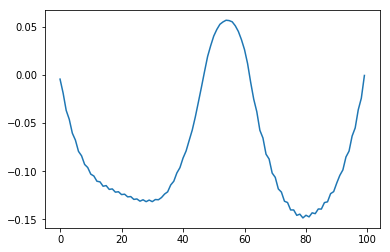

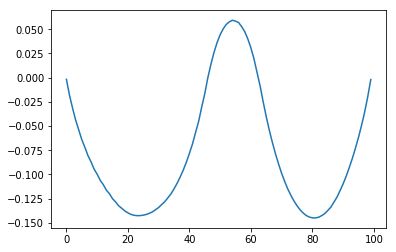

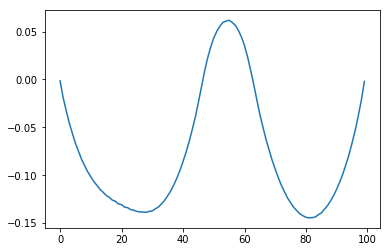

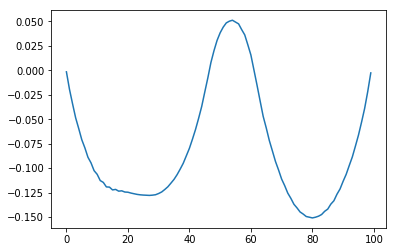

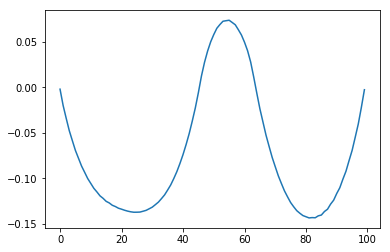

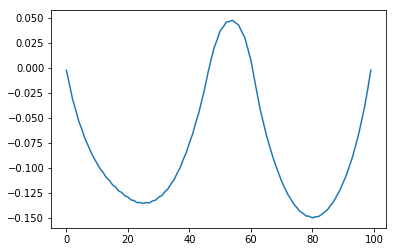

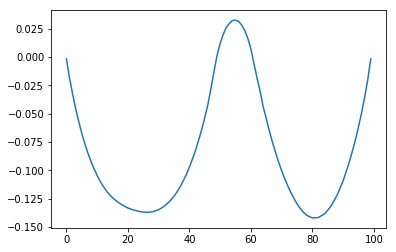

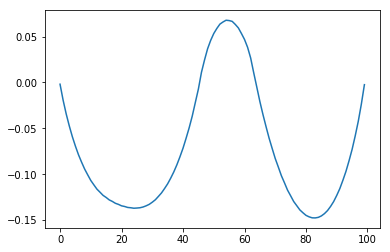

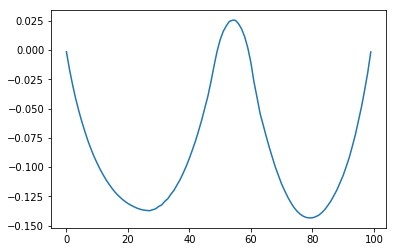

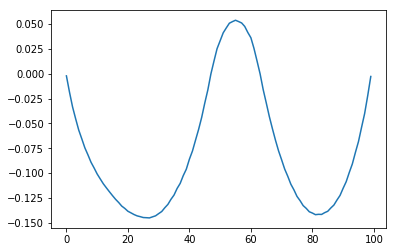

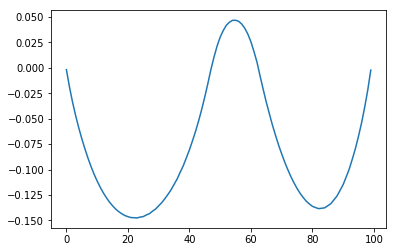

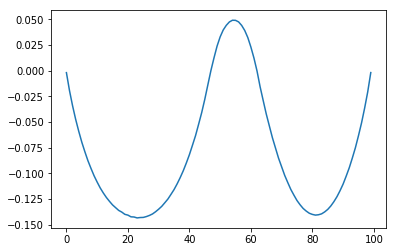

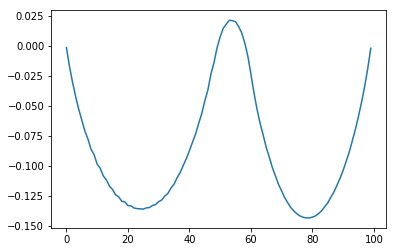

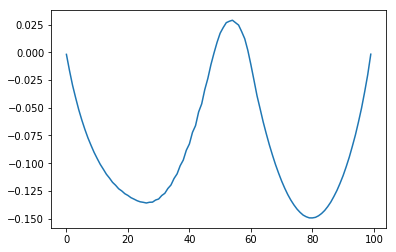

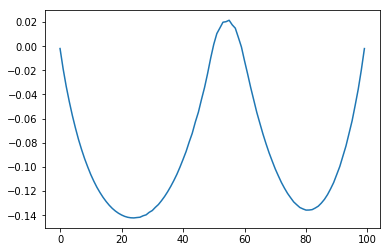

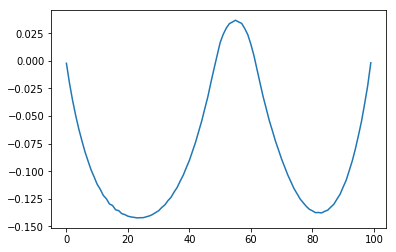

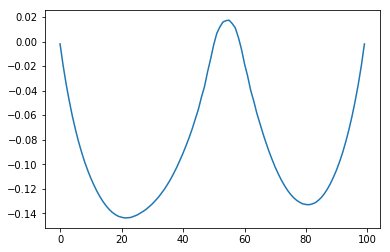

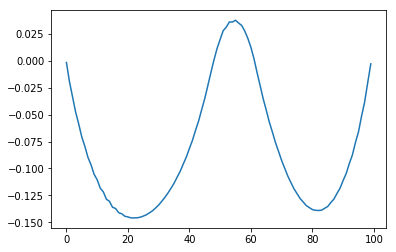

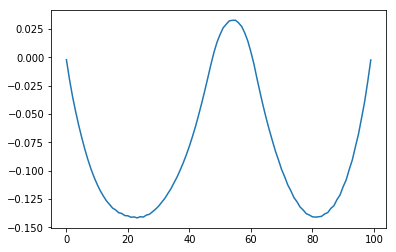

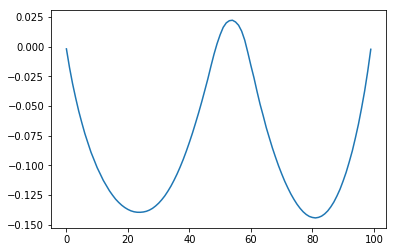

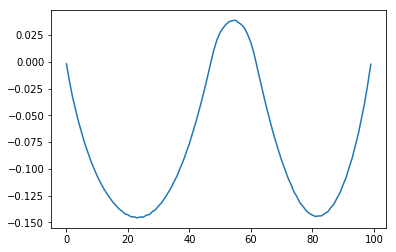

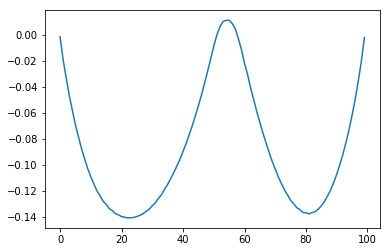

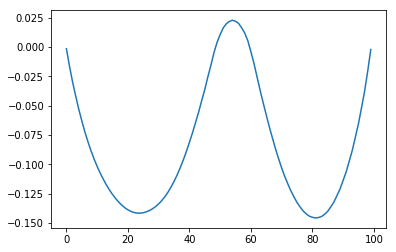

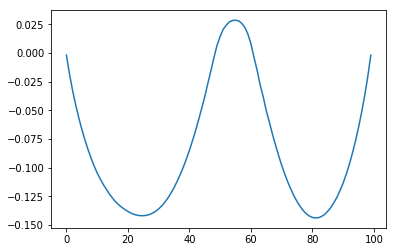

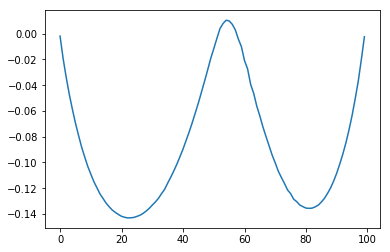

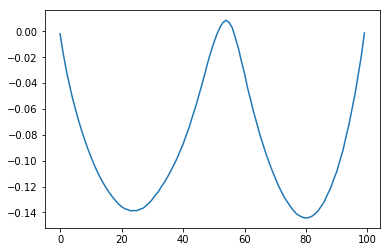

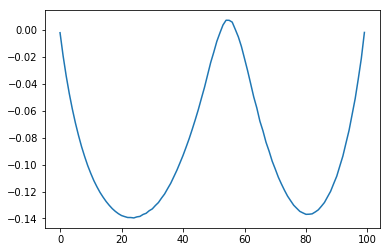

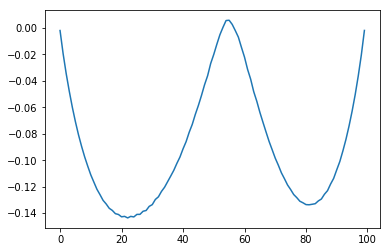

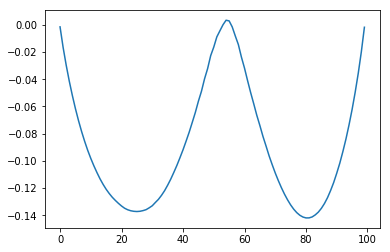

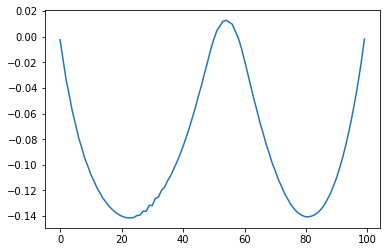

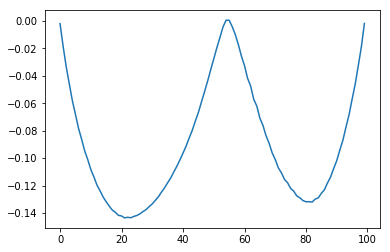

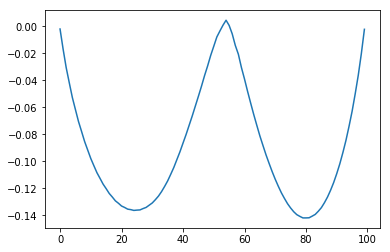

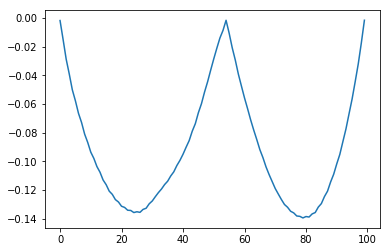

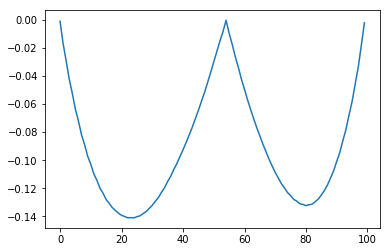

In [23]:
graph = np.array(graph)
for i in range(graph.shape[0]):
    plt.plot(graph[i][0])
    plt.show()

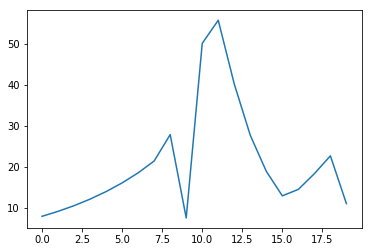

In [14]:
plt.plot(abs(psi_val[0]))

In [14]:
aa = np.arange(8).reshape(4, 2)
aa = tf.constant(aa, shape=[4, 2])
with tf.Session() as sess:
    print(sess.run(tf.reduce_sum(aa)))

28


In [ ]:
tf.int